#  Conditional Generative Adversarial Network

A Generative Adversarial Network (GAN) is a type of generative model.  It consists of two parts called the "generator" and the "discriminator".  The generator takes random values as input and transforms them into an output that (hopefully) resembles the training data.  The discriminator takes a set of samples as input and tries to distinguish the real training samples from the ones created by the generator.  Both of them are trained together.  The discriminator tries to get better and better at telling real from false data, while the generator tries to get better and better at fooling the discriminator.

A Conditional GAN (CGAN) allows additional inputs to the generator and discriminator that their output is conditioned on.  For example, this might be a class label, and the GAN tries to learn how the data distribution varies between classes.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Conditional_Generative_Adversarial_Networks.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands.

In [4]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

'2.8.1.dev'

For this example, we will create a data distribution consisting of a set of ellipses in 2D, each with a random position, shape, and orientation.  Each class corresponds to a different ellipse.  Let's randomly generate the ellipses.  For each one we select a random center position, X and Y size, and rotation angle.  We then create a transformation matrix that maps the unit circle to the ellipse.

In [5]:
import deepchem as dc
import numpy as np

n_classes = 4
batch_size=16
class_centers = np.random.uniform(-4, 4, (n_classes, 2))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle)],
         [xscale*np.sin(angle), yscale*np.cos(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

This function generates random data from the distribution.  For each point it chooses a random class, then a random position in that class' ellipse.

In [6]:
def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points)
    angle = 2*np.pi*np.random.random(n_points)
    points = (r*np.array([np.cos(angle), np.sin(angle)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points

Let's plot a bunch of random points drawn from this distribution to see what it looks like.  Points are colored based on their class label.

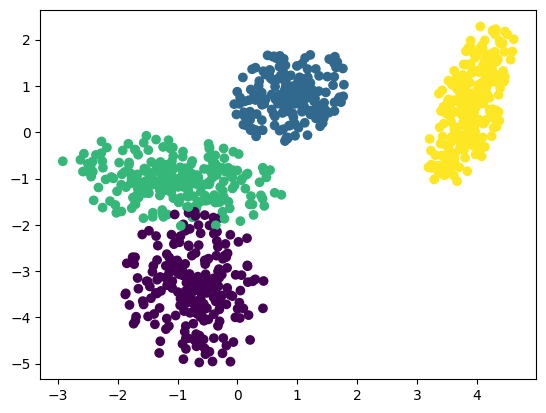

In [7]:
%matplotlib inline
import matplotlib.pyplot as plot
classes, points = generate_data(1000)
plot.scatter(x=points[:,0], y=points[:,1], c=classes)

Now let's create the model for our CGAN. Before that we will make the two most important parts of GAN :



*   **GENERATOR** - The generator is a model in GAN that produces synthetic data that resembles the training data.For generator we define a **class Generator**. It creates a model for our generator which takes input as a list of batch of noise input followed by any conditional input(in our case, the one-hot encoded class of each sample) and outputs the data as the same shape of our training data. 
*  **DISCRIMINATOR** – The discriminator is a model in GAN that evaluates data and determines whether it is real (from the training data) or fake (generated by the generator). For the discriminator, we define a **class Discriminator**. It creates a model that takes input as a list of batch of data samples (real or generated), along with any conditional input, and outputs a probability score indicating whether each sample is real or fake.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Creating the Generator
class Generator(nn.Module):
    def __init__(self, noise_input_shape, conditional_input_shape):
        super(Generator, self).__init__()
        self.noise_input_shape = noise_input_shape
        self.conditional_input_shape = conditional_input_shape
        self.noise_input_dim = noise_input_shape[1:]
        self.conditional_input_dim = conditional_input_shape[1:]

        input_dim = sum(self.noise_input_dim) + sum(self.conditional_input_dim)

        self.output = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=2)
        )

    def forward(self, inputs):
        noise_input, conditional_input = inputs
        inputs = torch.cat((noise_input, conditional_input), dim=1)
        return self.output(inputs)


# Creating the Discriminator
class Discriminator(nn.Module):
    def __init__(self, data_input_shape, conditional_input_shape):
        super(Discriminator, self).__init__()
        self.data_input_shape = data_input_shape
        self.data_input_dim = data_input_shape[1:]
        self.conditional_input_shape = conditional_input_shape
        self.conditional_input_dim = conditional_input_shape[1:]

        input_dim = sum(self.data_input_dim) + sum(self.conditional_input_dim)

        self.output = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        data_input, conditional_input = inputs
        inputs = torch.cat((data_input, conditional_input), dim=1)
        return self.output(inputs)


Now we shall build the  model for our CGAN.  DeepChem's GAN class makes this very easy.  We just subclass it and implement a few methods.  The two most important are:

- `create_generator()` A function that returns a generator build from our **GENERATOR** class .  The model build from this function generates synthentic data points resembling the training dataset

- `create_discriminator()` A function that returns a discriminator built from our DISCRIMINATOR class. The model built from this function evaluates input data points, along with any conditional inputs, and outputs a probability score indicating whether each data point is real (from the training dataset) or fake (generated by the generator).

In this case, we use very simple models.  They just concatenate the inputs together and pass them through a few dense layers.  Notice that the final layer of the discriminator uses a sigmoid activation.  This ensures it produces an output between 0 and 1 that can be interpreted as a probability.

We also need to implement a few methods that define the shapes of the various inputs.  We specify that the random noise provided to the generator should consist of ten numbers for each sample; that each data sample consists of two numbers (the X and Y coordinates of a point in 2D); and that the conditional input consists of `n_classes` numbers for each sample (the one-hot encoded class index).

In [ ]:
class ExampleGAN(dc.models.torch_models.GANModel):
    def get_noise_input_shape(self):
       return (batch_size,10,)

    def get_data_input_shapes(self):
       return [(batch_size,2,)]

    def get_conditional_input_shapes(self):
      return [(batch_size,n_classes,)]

    def create_generator(self):
      noise_dim = self.get_noise_input_shape()
      conditional_dim = self.get_conditional_input_shapes()[0]
      return nn.Sequential(Generator(noise_dim,conditional_dim))

    def create_discriminator(self):
      data_dim = self.get_data_input_shapes()[0]
      conditional_dim = self.get_conditional_input_shapes()[0]
      return nn.Sequential(Discriminator(data_dim,conditional_dim))


gan = ExampleGAN(learning_rate=1e-4)

Now to fit the model.  We do this by calling `fit_gan()`.  The argument is an iterator that produces batches of training data.  More specifically, it needs to produce dicts that map all data inputs and conditional inputs to the values to use for them.  In our case we can easily create as much random data as we need, so we define a generator that calls the `generate_data()` function defined above for each new batch.

In [10]:
def iterbatches(batches):
  for i in range(batches):
    classes, points = generate_data(gan.batch_size)
    classes = dc.metrics.to_one_hot(classes, n_classes)
    yield {gan.data_inputs[0]: points, gan.conditional_inputs[0]: classes}

gan.fit_gan(iterbatches(8000))

Ending global_step 999: generator average loss 0.735522, discriminator average loss 1.16404
Ending global_step 1999: generator average loss 1.2401, discriminator average loss 0.844707
Ending global_step 2999: generator average loss 1.30449, discriminator average loss 0.966655
Ending global_step 3999: generator average loss 1.05614, discriminator average loss 1.12987
Ending global_step 4999: generator average loss 0.718763, discriminator average loss 1.40146
Ending global_step 5999: generator average loss 0.690799, discriminator average loss 1.39385
Ending global_step 6999: generator average loss 0.695314, discriminator average loss 1.38775
Ending global_step 7999: generator average loss 0.694297, discriminator average loss 1.38649
TIMING: model fitting took 101.900 s


Have the trained model generate some data, and see how well it matches the training distribution we plotted before.

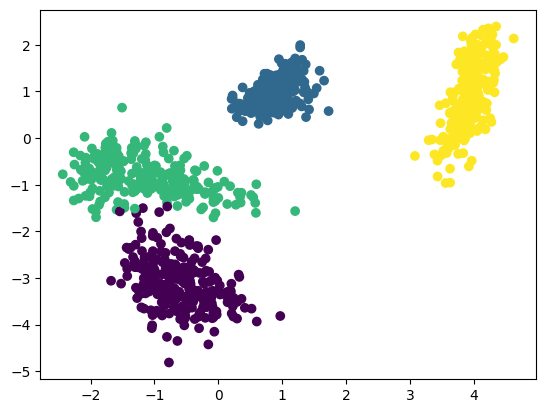

In [11]:
classes, points = generate_data(1000)
one_hot_classes = dc.metrics.to_one_hot(classes, n_classes)
gen_points = gan.predict_gan_generator(conditional_inputs=[one_hot_classes])
plot.scatter(x=gen_points[:,0], y=gen_points[:,1], c=classes)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!